In [1]:
# 2021/11/08 업데이트 내용:
# 주소 나열 방법을 지번주소 대신 시군구, 본번, 부번으로 나열하여 조금 더 보기 편하게 바뀜.

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [3]:
target_gu = '은평구' # 구 명
target_dong = '' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2018 # 검색 시작 계약 년도: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20211123'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [33]:
def data_prep(starting_year=2018):    
    
    basedir = './국토교통부_실거래가_공개시스템/분양입주권/'
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        splitted_filename = f.split('_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year < starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        '''if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])'''
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
    
    concat_df['본번'] = concat_df['번지'].apply(lambda x: x.split('-')[0])
    concat_df['부번'] = concat_df['번지'].apply(lambda x: x.split('-')[1])
        
    cols_to_drop = ['계약년월', '계약일', '지번주소']
        
    concat_df = concat_df[['지번주소'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    #concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [34]:
bunyang_df = data_prep()
bunyang_df['부동산유형'] = '분양입주권'
print(bunyang_df.shape)
bunyang_df.head()

16it [00:00, 799.78it/s]

(5905, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
0,서울특별시 강남구 개포동 138-0,서울특별시 강남구 개포동,138-0,디에이치 아너힐즈,106.6695,232741,18,분,NaN,NaN,NaN,2018-02-03,2181.888919,138,0,분양입주권
1,서울특별시 강남구 개포동 138-0,서울특별시 강남구 개포동,138-0,디에이치 아너힐즈,84.3558,139591,9,입,NaN,NaN,NaN,2018-04-10,1654.788408,138,0,분양입주권
2,서울특별시 강남구 개포동 656-0,서울특별시 강남구 개포동,656-0,래미안 강남포레스트,59.9200,127000,11,입,NaN,NaN,NaN,2018-05-17,2119.492657,656,0,분양입주권
3,서울특별시 강남구 개포동 656-0,서울특별시 강남구 개포동,656-0,래미안 강남포레스트,84.5900,163122,22,입,NaN,NaN,NaN,2018-07-03,1928.383970,656,0,분양입주권
4,서울특별시 강남구 개포동 656-0,서울특별시 강남구 개포동,656-0,래미안 강남포레스트,74.6600,180278,10,입,NaN,NaN,NaN,2018-08-25,2414.653094,656,0,분양입주권


In [56]:
inv_df = bunyang_df[bunyang_df['지번주소'].str.contains('은평구 ')]
print(inv_df.shape)
inv_df.head()

(961, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
1969,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,67000,7,분,NaN,NaN,NaN,2018-01-04,788.699235,19,0,분양입주권
1970,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,66210,6,입,NaN,NaN,NaN,2018-01-10,779.399647,19,0,분양입주권
1971,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.98,59801,19,입,NaN,NaN,NaN,2018-01-12,997.015672,19,0,분양입주권
1972,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,66505,19,입,NaN,NaN,NaN,2018-01-12,782.872278,19,0,분양입주권
1973,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.99,52165,3,입,NaN,NaN,NaN,2018-01-18,869.561594,19,0,분양입주권


In [57]:
inv_df = inv_df.sort_values(['시군구', '본번', '부번', '분/입구분', '계약날짜'])
print(inv_df.shape)
inv_df.head()

(961, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
1969,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,67000,7,분,NaN,NaN,NaN,2018-01-04,788.699235,19,0,분양입주권
2003,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.99,57402,1,분,NaN,NaN,NaN,2018-05-15,956.859477,19,0,분양입주권
2006,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.99,59900,1,분,NaN,NaN,NaN,2018-05-30,998.499750,19,0,분양입주권
1970,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,66210,6,입,NaN,NaN,NaN,2018-01-10,779.399647,19,0,분양입주권
1971,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.98,59801,19,입,NaN,NaN,NaN,2018-01-12,997.015672,19,0,분양입주권


In [58]:
inv_df['분/입구분'].value_counts()

입    775
분    186
Name: 분/입구분, dtype: int64

In [59]:
inv_df['분/입구분'].str.contains('분').sum()

186

In [60]:
count = 0
for addr in inv_df['지번주소'].unique():
    addr_df = inv_df[inv_df['지번주소'] == addr]
    if addr_df['분/입구분'].str.contains('분').sum() > 0:
        print(addr_df.shape)
        display(addr_df)
    
    if count > 5:
        break

(50, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
1969,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,67000,7,분,NaN,NaN,NaN,2018-01-04,788.699235,19,0,분양입주권
2003,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.99,57402,1,분,NaN,NaN,NaN,2018-05-15,956.859477,19,0,분양입주권
2006,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.99,59900,1,분,NaN,NaN,NaN,2018-05-30,998.499750,19,0,분양입주권
1970,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,66210,6,입,NaN,NaN,NaN,2018-01-10,779.399647,19,0,분양입주권
1971,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.98,59801,19,입,NaN,NaN,NaN,2018-01-12,997.015672,19,0,분양입주권
1972,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,66505,19,입,NaN,NaN,NaN,2018-01-12,782.872278,19,0,분양입주권
1973,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.99,52165,3,입,NaN,NaN,NaN,2018-01-18,869.561594,19,0,분양입주권
1974,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,67357,13,입,NaN,NaN,NaN,2018-01-24,792.901707,19,0,분양입주권
1975,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,59.92,57411,5,입,NaN,NaN,NaN,2018-01-26,958.127503,19,0,분양입주권
1976,서울특별시 은평구 녹번동 19-0,서울특별시 은평구 녹번동,19-0,래미안 베라힐즈,84.95,70000,10,입,NaN,NaN,NaN,2018-01-29,824.014126,19,0,분양입주권


(40, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2023,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,84.898,64812,7,분,NaN,NaN,NaN,2018-01-12,763.410210,53,0,분양입주권
2033,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,84.900,60000,4,분,NaN,NaN,NaN,2018-02-27,706.713781,53,0,분양입주권
2034,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,84.900,60000,4,분,NaN,NaN,NaN,2018-02-27,706.713781,53,0,분양입주권
2045,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,84.900,80990,2,분,NaN,NaN,NaN,2018-08-03,953.945819,53,0,분양입주권
2056,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,84.900,88000,4,분,NaN,NaN,NaN,2018-09-18,1036.513545,53,0,분양입주권
2018,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,59.938,41000,1,입,NaN,NaN,NaN,2018-01-02,684.040175,53,0,분양입주권
2019,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,59.900,55945,13,입,NaN,NaN,NaN,2018-01-04,933.973289,53,0,분양입주권
2020,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,59.938,57705,20,입,NaN,NaN,NaN,2018-01-08,962.744836,53,0,분양입주권
2021,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,84.900,68205,17,입,NaN,NaN,NaN,2018-01-10,803.356890,53,0,분양입주권
2022,서울특별시 은평구 녹번동 53-0,서울특별시 은평구 녹번동,53-0,힐스테이트 녹번,59.938,55637,6,입,NaN,NaN,NaN,2018-01-11,928.242517,53,0,분양입주권


(2, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
5460,서울특별시 은평구 대조동 197-1,서울특별시 은평구 대조동,197-1,유진 아이디움,14.03,17020,10,분,NaN,NaN,NaN,2020-01-22,1213.114754,197,1,분양입주권
5461,서울특별시 은평구 대조동 197-1,서울특별시 은평구 대조동,197-1,유진 아이디움,14.03,17090,13,분,NaN,NaN,NaN,2020-01-23,1218.104063,197,1,분양입주권


(31, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2088,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,114.99,85000,6,분,NaN,NaN,NaN,2018-09-05,739.194713,645,0,분양입주권
2089,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,114.99,89500,3,분,NaN,NaN,NaN,2018-10-22,778.328550,645,0,분양입주권
2059,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,48900,14,입,NaN,NaN,NaN,2018-01-03,815.135856,645,0,분양입주권
2060,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,49000,6,입,NaN,NaN,NaN,2018-01-16,816.802800,645,0,분양입주권
2061,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,48500,2,입,NaN,NaN,NaN,2018-01-19,808.468078,645,0,분양입주권
2062,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,52900,8,입,NaN,NaN,NaN,2018-01-21,881.813636,645,0,분양입주권
2063,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,84.98,63000,10,입,NaN,NaN,NaN,2018-01-27,741.350906,645,0,분양입주권
2064,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,50000,12,입,NaN,NaN,NaN,2018-02-03,833.472245,645,0,분양입주권
2065,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,49500,16,입,NaN,NaN,NaN,2018-02-04,825.137523,645,0,분양입주권
2066,서울특별시 은평구 불광동 645-0,서울특별시 은평구 불광동,645-0,불광롯데캐슬,59.99,49000,14,입,NaN,NaN,NaN,2018-02-07,816.802800,645,0,분양입주권


(10, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
5493,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,59.96,105000,14,분,20201229.0,NaN,NaN,2020-11-09,1751.167445,361,0,분양입주권
5486,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,59.96,95000,15,입,NaN,NaN,NaN,2020-06-27,1584.389593,361,0,분양입주권
5487,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,59.96,98000,9,입,NaN,NaN,NaN,2020-07-01,1634.422949,361,0,분양입주권
5488,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,84.87,120810,12,입,NaN,NaN,NaN,2020-07-04,1423.471191,361,0,분양입주권
5489,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,84.87,120810,17,입,NaN,NaN,NaN,2020-07-11,1423.471191,361,0,분양입주권
5490,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,59.96,100000,10,입,NaN,NaN,NaN,2020-07-18,1667.778519,361,0,분양입주권
5491,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,59.96,97500,13,입,NaN,NaN,NaN,2020-07-22,1626.084056,361,0,분양입주권
5492,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,84.93,118700,12,입,NaN,NaN,NaN,2020-08-07,1397.621571,361,0,분양입주권
5494,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,59.96,105000,14,입,NaN,NaN,NaN,2020-11-09,1751.167445,361,0,분양입주권
5857,서울특별시 은평구 수색동 361-0,서울특별시 은평구 수색동,361-0,DMC롯데캐슬더퍼스트,84.87,129800,11,입,NaN,-,-,2021-01-09,1529.397903,361,0,분양입주권


(20, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2111,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,75.720,41950,3,분,NaN,NaN,NaN,2018-01-03,554.014791,19,190,분양입주권
2112,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.930,46000,12,분,NaN,NaN,NaN,2018-01-19,639.510635,19,190,분양입주권
2113,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.930,41500,2,분,NaN,NaN,NaN,2018-01-22,576.949812,19,190,분양입주권
2114,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.990,47813,12,분,NaN,NaN,NaN,2018-02-09,664.161689,19,190,분양입주권
2115,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,59.940,40210,8,분,NaN,NaN,NaN,2018-02-10,670.837504,19,190,분양입주권
2116,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.990,47040,14,분,NaN,NaN,NaN,2018-02-11,653.424087,19,190,분양입주권
2117,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.990,43740,3,분,NaN,NaN,NaN,2018-02-11,607.584387,19,190,분양입주권
2118,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.938,45900,5,분,NaN,NaN,NaN,2018-02-21,638.049431,19,190,분양입주권
2119,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,71.930,45502,8,분,NaN,NaN,NaN,2018-03-02,632.587238,19,190,분양입주권
2120,서울특별시 은평구 신사동 19-190,서울특별시 은평구 신사동,19-190,은평 신사 효성해링턴 플레이스,75.720,40950,2,분,NaN,NaN,NaN,2018-03-14,540.808241,19,190,분양입주권


(3, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2131,서울특별시 은평구 신사동 372-0,서울특별시 은평구 신사동,372-0,응암역 효성해링턴플레이스,75.72,48650,3,분,NaN,NaN,NaN,2018-08-04,642.498679,372,0,분양입주권
2132,서울특별시 은평구 신사동 372-0,서울특별시 은평구 신사동,372-0,응암역 효성해링턴플레이스,59.99,45350,2,분,NaN,NaN,NaN,2018-09-06,755.959327,372,0,분양입주권
2133,서울특별시 은평구 신사동 372-0,서울특별시 은평구 신사동,372-0,응암역 효성해링턴플레이스,71.93,50800,4,분,NaN,NaN,NaN,2018-09-06,706.242180,372,0,분양입주권


(115, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2294,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,72900,24,분,NaN,NaN,NaN,2018-09-22,858.617802,419,0,분양입주권
2295,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,59960,17,분,NaN,NaN,NaN,2018-09-27,706.210198,419,0,분양입주권
2296,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,100.9852,70000,19,분,NaN,NaN,NaN,2018-09-27,693.170880,419,0,분양입주권
2297,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,51596,2,분,NaN,NaN,NaN,2018-09-27,607.698822,419,0,분양입주권
2298,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,59.9335,52143,2,분,NaN,NaN,NaN,2018-09-27,870.014266,419,0,분양입주권
2299,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,54760,19,분,NaN,NaN,NaN,2018-09-28,644.964483,419,0,분양입주권
2300,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,52623,10,분,NaN,NaN,NaN,2018-10-01,619.794850,419,0,분양입주권
2301,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,54050,15,분,NaN,NaN,NaN,2018-10-08,636.602088,419,0,분양입주권
2302,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,54686,25,분,NaN,NaN,NaN,2018-10-09,644.092910,419,0,분양입주권
2303,서울특별시 은평구 응암동 419-0,서울특별시 은평구 응암동,419-0,백련산 SK VIEW IPARK,84.9039,77870,10,분,NaN,NaN,NaN,2018-10-10,917.154571,419,0,분양입주권


(33, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2364,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.901,54612,5,분,NaN,NaN,NaN,2018-01-09,643.243307,626,108,분양입주권
2365,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.900,57462,14,분,NaN,NaN,NaN,2018-01-15,676.819788,626,108,분양입주권
2366,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.900,59990,13,분,NaN,NaN,NaN,2018-02-11,706.595995,626,108,분양입주권
2367,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.901,54612,4,분,NaN,NaN,NaN,2018-02-17,643.243307,626,108,분양입주권
2368,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.901,46132,1,분,NaN,NaN,NaN,2018-02-20,543.362269,626,108,분양입주권
2369,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.901,64362,12,분,NaN,NaN,NaN,2018-03-15,758.082944,626,108,분양입주권
2370,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.779,52654,12,분,NaN,NaN,NaN,2018-03-31,621.073615,626,108,분양입주권
2371,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,59.780,49553,2,분,NaN,NaN,NaN,2018-04-08,828.922717,626,108,분양입주권
2372,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.900,67612,14,분,NaN,NaN,NaN,2018-05-31,796.372203,626,108,분양입주권
2373,서울특별시 은평구 응암동 626-108,서울특별시 은평구 응암동,626-108,백련산파크자이,84.900,61580,6,분,NaN,NaN,NaN,2018-06-06,725.323910,626,108,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2390,서울특별시 은평구 응암동 764-0,서울특별시 은평구 응암동,764-0,백련산힐스테이트 4차,84.98,58892,11,분,NaN,NaN,NaN,2018-01-28,693.01012,764,0,분양입주권


(3, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
4584,서울특별시 은평구 응암동 766-0,서울특별시 은평구 응암동,766-0,백련산파크자이,84.901,66550,11,분,NaN,NaN,NaN,2019-02-22,783.854136,766,0,분양입주권
4587,서울특별시 은평구 응암동 766-0,서울특별시 은평구 응암동,766-0,백련산파크자이,84.669,59000,2,분,NaN,NaN,NaN,2019-04-26,696.831190,766,0,분양입주권
4588,서울특별시 은평구 응암동 766-0,서울특별시 은평구 응암동,766-0,백련산파크자이,84.901,65500,5,분,NaN,NaN,NaN,2019-05-02,771.486790,766,0,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2425,서울특별시 은평구 진관동 105-0,서울특별시 은평구 진관동,105-0,은평뉴타운 마고정2단지,167.14,71201,4,분,NaN,NaN,NaN,2018-02-27,425.996171,105,0,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2421,서울특별시 은평구 진관동 106-0,서울특별시 은평구 진관동,106-0,은평뉴타운 마고정(동부센트레빌11단지),167.49,71753,1,분,NaN,NaN,NaN,2018-01-03,428.401696,106,0,분양입주권


(3, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2422,서울특별시 은평구 진관동 107-0,서울특별시 은평구 진관동,107-0,은평뉴타운 마고정(센트레빌3단지),167.14,70455,2,분,NaN,NaN,NaN,2018-01-20,421.532847,107,0,분양입주권
2424,서울특별시 은평구 진관동 107-0,서울특별시 은평구 진관동,107-0,은평뉴타운 마고정(센트레빌3단지),167.14,77500,14,분,NaN,NaN,NaN,2018-06-20,463.683140,107,0,분양입주권
2423,서울특별시 은평구 진관동 107-0,서울특별시 은평구 진관동,107-0,은평뉴타운 마고정(센트레빌3단지),167.14,68683,1,입,NaN,NaN,NaN,2018-05-20,410.930956,107,0,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2447,서울특별시 은평구 진관동 13-0,서울특별시 은평구 진관동,13-0,은평뉴타운상림마을(현대아이파크B-3),167.69,73523,8,분,NaN,NaN,NaN,2018-05-26,438.445942,13,0,분양입주권


(3, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2440,서울특별시 은평구 진관동 140-0,서울특별시 은평구 진관동,140-0,은평뉴타운 폭포동(힐스테이트D-9),166.98,92000,2,분,NaN,NaN,NaN,2018-04-01,550.964187,140,0,분양입주권
2441,서울특별시 은평구 진관동 140-0,서울특별시 은평구 진관동,140-0,은평뉴타운 폭포동(힐스테이트D-9),166.96,95000,15,분,NaN,NaN,NaN,2018-05-15,568.998563,140,0,분양입주권
2442,서울특별시 은평구 진관동 140-0,서울특별시 은평구 진관동,140-0,은평뉴타운 폭포동(힐스테이트D-9),166.96,83800,12,분,NaN,NaN,NaN,2018-05-28,501.916627,140,0,분양입주권


(2, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2433,서울특별시 은평구 진관동 154-0,서울특별시 은평구 진관동,154-0,은평뉴타운 제각말 푸르지오(5-1단지),134.74,63038,6,분,NaN,NaN,NaN,2018-05-31,467.849191,154,0,분양입주권
2434,서울특별시 은평구 진관동 154-0,서울특별시 은평구 진관동,154-0,은평뉴타운 제각말 푸르지오(5-1단지),134.74,63584,11,분,NaN,NaN,NaN,2018-08-03,471.901440,154,0,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2435,서울특별시 은평구 진관동 155-0,서울특별시 은평구 진관동,155-0,은평뉴타운 제각말 푸르지오(5-2단지),134.74,64478,7,분,NaN,NaN,NaN,2018-05-21,478.536441,155,0,분양입주권


(6, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2412,서울특별시 은평구 진관동 25-0,서울특별시 은평구 진관동,25-0,은평뉴타운 구파발(삼성래미안9단지),166.75,70000,6,분,NaN,NaN,NaN,2018-01-04,419.790105,25,0,분양입주권
2413,서울특별시 은평구 진관동 25-0,서울특별시 은평구 진관동,25-0,은평뉴타운 구파발(삼성래미안9단지),134.83,60000,1,분,NaN,NaN,NaN,2018-01-08,445.004821,25,0,분양입주권
2414,서울특별시 은평구 진관동 25-0,서울특별시 은평구 진관동,25-0,은평뉴타운 구파발(삼성래미안9단지),166.75,66892,3,분,NaN,NaN,NaN,2018-01-16,401.151424,25,0,분양입주권
2415,서울특별시 은평구 진관동 25-0,서울특별시 은평구 진관동,25-0,은평뉴타운 구파발(삼성래미안9단지),166.75,69000,8,분,NaN,NaN,NaN,2018-04-06,413.793103,25,0,분양입주권
2416,서울특별시 은평구 진관동 25-0,서울특별시 은평구 진관동,25-0,은평뉴타운 구파발(삼성래미안9단지),166.98,65504,1,분,NaN,NaN,NaN,2018-05-21,392.286501,25,0,분양입주권
2417,서울특별시 은평구 진관동 25-0,서울특별시 은평구 진관동,25-0,은평뉴타운 구파발(삼성래미안9단지),166.75,67075,2,분,NaN,NaN,NaN,2018-05-24,402.248876,25,0,분양입주권


(11, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2401,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),134.43,61900,6,분,NaN,NaN,NaN,2018-01-12,460.462694,27,0,분양입주권
2402,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,69000,10,분,NaN,NaN,NaN,2018-04-16,415.187436,27,0,분양입주권
2403,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,69837,8,분,NaN,NaN,NaN,2018-05-22,420.223840,27,0,분양입주권
2404,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,65712,2,분,NaN,NaN,NaN,2018-05-28,395.402852,27,0,분양입주권
2405,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,68174,4,분,NaN,NaN,NaN,2018-06-04,410.217221,27,0,분양입주권
2406,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,66000,2,분,NaN,NaN,NaN,2018-06-12,397.135808,27,0,분양입주권
2407,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,70500,9,분,NaN,NaN,NaN,2018-06-16,424.213250,27,0,분양입주권
2408,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,70235,8,분,NaN,NaN,NaN,2018-06-30,422.618689,27,0,분양입주권
2409,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),134.73,61329,10,분,NaN,NaN,NaN,2018-07-02,455.199287,27,0,분양입주권
2410,서울특별시 은평구 진관동 27-0,서울특별시 은평구 진관동,27-0,은평뉴타운 구파발(금호어울림10단지),166.19,68820,6,분,NaN,NaN,NaN,2018-08-24,414.104338,27,0,분양입주권


(2, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2445,서울특별시 은평구 진관동 5-0,서울특별시 은평구 진관동,5-0,은평뉴타운상림마을(푸르지오C-5),167.69,66564,1,분,NaN,NaN,NaN,2018-06-18,396.946747,5,0,분양입주권
2446,서울특별시 은평구 진관동 5-0,서울특별시 은평구 진관동,5-0,은평뉴타운상림마을(푸르지오C-5),167.69,69784,3,분,NaN,NaN,NaN,2018-07-10,416.148846,5,0,분양입주권


(2, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
4618,서울특별시 은평구 진관동 62-0,서울특별시 은평구 진관동,62-0,은평 스카이뷰 자이,84.3363,75000,13,분,NaN,NaN,NaN,2019-03-09,889.296780,62,0,분양입주권
4619,서울특별시 은평구 진관동 62-0,서울특별시 은평구 진관동,62-0,은평 스카이뷰 자이,84.7488,67000,21,분,NaN,NaN,NaN,2019-03-23,790.571666,62,0,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2444,서울특별시 은평구 진관동 66-0,서울특별시 은평구 진관동,66-0,은평뉴타운꿈에그린,59.99,40600,9,분,NaN,NaN,NaN,2018-02-21,676.779463,66,0,분양입주권


(3, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2418,서울특별시 은평구 진관동 66-13,서울특별시 은평구 진관동,66-13,은평뉴타운 꿈에그린,59.98,44990,10,분,NaN,NaN,NaN,2018-02-11,750.083361,66,13,분양입주권
2419,서울특별시 은평구 진관동 66-13,서울특별시 은평구 진관동,66-13,은평뉴타운 꿈에그린,59.99,39600,8,분,NaN,NaN,NaN,2018-02-25,660.110018,66,13,분양입주권
2420,서울특별시 은평구 진관동 66-13,서울특별시 은평구 진관동,66-13,은평뉴타운 꿈에그린,59.99,39930,16,분,NaN,NaN,NaN,2018-03-16,665.610935,66,13,분양입주권


(7, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2426,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.71,70506,4,분,NaN,NaN,NaN,2018-03-09,420.404269,84,0,분양입주권
2427,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.71,69855,2,분,NaN,NaN,NaN,2018-05-23,416.522569,84,0,분양입주권
2428,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.71,71235,7,분,NaN,NaN,NaN,2018-06-08,424.751058,84,0,분양입주권
2429,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.71,74000,2,분,NaN,NaN,NaN,2018-06-13,441.237851,84,0,분양입주권
2430,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.74,71218,4,분,NaN,NaN,NaN,2018-06-13,424.573745,84,0,분양입주권
2431,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.71,71400,4,분,NaN,NaN,NaN,2018-08-03,425.734900,84,0,분양입주권
2432,서울특별시 은평구 진관동 84-0,서울특별시 은평구 진관동,84-0,은평뉴타운 우물골(두산위브7단지),167.75,69727,2,분,NaN,NaN,NaN,2018-08-20,415.660209,84,0,분양입주권


(33, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2448,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.3363,58670,9,분,NaN,NaN,NaN,2018-01-08,695.667228,88,13,분양입주권
2449,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.3363,58420,6,분,NaN,NaN,NaN,2018-01-20,692.702905,88,13,분양입주권
2450,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.7488,59400,20,분,NaN,NaN,NaN,2018-02-10,700.894880,88,13,분양입주권
2451,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.3363,59530,20,분,NaN,NaN,NaN,2018-02-14,705.864497,88,13,분양입주권
2452,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.7488,59700,19,분,NaN,NaN,NaN,2018-02-23,704.434753,88,13,분양입주권
2453,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.7488,59024,10,분,NaN,NaN,NaN,2018-02-24,696.458239,88,13,분양입주권
2454,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.7488,60670,28,분,NaN,NaN,NaN,2018-03-12,715.880343,88,13,분양입주권
2455,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.3363,61225,19,분,NaN,NaN,NaN,2018-03-14,725.962604,88,13,분양입주권
2456,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.3363,60380,17,분,NaN,NaN,NaN,2018-03-26,715.943194,88,13,분양입주권
2457,서울특별시 은평구 진관동 88-13,서울특별시 은평구 진관동,88-13,은평스카이뷰자이,84.3363,59830,18,분,NaN,NaN,NaN,2018-04-04,709.421684,88,13,분양입주권


(4, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2436,서울특별시 은평구 진관동 92-0,서울특별시 은평구 진관동,92-0,은평뉴타운 제각말 푸르지오(5-4단지),134.74,64078,6,분,NaN,NaN,NaN,2018-05-15,475.567760,92,0,분양입주권
2437,서울특별시 은평구 진관동 92-0,서울특별시 은평구 진관동,92-0,은평뉴타운 제각말 푸르지오(5-4단지),134.74,64038,7,분,NaN,NaN,NaN,2018-05-18,475.270892,92,0,분양입주권
2438,서울특별시 은평구 진관동 92-0,서울특별시 은평구 진관동,92-0,은평뉴타운 제각말 푸르지오(5-4단지),134.74,64200,6,분,NaN,NaN,NaN,2018-05-24,476.473208,92,0,분양입주권
2439,서울특별시 은평구 진관동 92-0,서울특별시 은평구 진관동,92-0,은평뉴타운 제각말 푸르지오(5-4단지),134.74,62250,3,분,NaN,NaN,NaN,2018-06-16,462.000891,92,0,분양입주권


(1, 16)


,지번주소,시군구,번지,건물(단지)명,전용면적(㎡),거래금액(만원),층,분/입구분,해제사유발생일,거래유형,중개사소재지,계약날짜,단가(만원/㎡),본번,부번,부동산유형
2443,서울특별시 은평구 진관동 BL154-0,서울특별시 은평구 진관동,BL154-0,은평뉴타운3지구C공구 8블록,134.74,63900,11,분,NaN,NaN,NaN,2018-05-15,474.246697,BL154,0,분양입주권


In [ ]:
ib_df = inv_df['']

In [10]:
house_df = pd.concat([bunyang_df]).sort_values(['시군구', '본번', '부번', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df
print(house_df.shape)
house_df.head()

(277665, 18)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,71000,4,1992,-,-,매매,26,2018-01-20,2139.843279,29,아파트
1,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,71300,4,1992,-,-,매매,26,2018-01-27,2148.884870,29,아파트
2,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,74000,13,1992,-,-,매매,26,2018-01-30,2230.259192,29,아파트
3,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,56000,11,1992,-,-,매매,26,2018-01-31,1687.763713,29,아파트
4,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,74000,4,1992,-,-,매매,26,2018-01-31,2230.259192,29,아파트


In [11]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [12]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [13]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [14]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [15]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(787, 20)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
251272,서울특별시 은평구 갈현동 136-6,연서로25길 23-9,서울특별시 은평구 갈현동,136.0,6.0,대훈,82.62,55300,3,2002,-,-,매매,19,2021-06-26,669.329460,19,아파트,은평구,갈현동
251273,서울특별시 은평구 갈현동 241-9,갈현로29길 37-2,서울특별시 은평구 갈현동,241.0,9.0,한아름,74.14,44500,4,2003,-,-,매매,18,2021-10-23,600.215808,18,아파트,은평구,갈현동
251282,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,64.63,39800,7,1991,-,-,매매,30,2021-10-11,615.813090,30,아파트,은평구,갈현동
251285,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,76.34,44000,10,1991,-,-,매매,30,2021-08-01,576.368876,30,아파트,은평구,갈현동
251306,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,79.11,57000,8,1991,-,-,매매,30,2021-08-14,720.515738,30,아파트,은평구,갈현동


In [16]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(1837, 20)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
251272,서울특별시 은평구 갈현동 136-6,연서로25길 23-9,서울특별시 은평구 갈현동,136.0,6.0,대훈,82.62,55300,3,2002,-,-,매매,19,2021-06-26,669.329460,19,아파트,은평구,갈현동
251273,서울특별시 은평구 갈현동 241-9,갈현로29길 37-2,서울특별시 은평구 갈현동,241.0,9.0,한아름,74.14,44500,4,2003,-,-,매매,18,2021-10-23,600.215808,18,아파트,은평구,갈현동
251282,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,64.63,39800,7,1991,-,-,매매,30,2021-10-11,615.813090,30,아파트,은평구,갈현동
251284,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,76.34,42600,5,1991,-,-,매매,30,2021-01-04,558.029866,30,아파트,은평구,갈현동
251285,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,76.34,44000,10,1991,-,-,매매,30,2021-08-01,576.368876,30,아파트,은평구,갈현동


In [17]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(5292, 20)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
251272,서울특별시 은평구 갈현동 136-6,연서로25길 23-9,서울특별시 은평구 갈현동,136.0,6.0,대훈,82.62,55300,3,2002,-,-,매매,19,2021-06-26,669.329460,19,아파트,은평구,갈현동
251273,서울특별시 은평구 갈현동 241-9,갈현로29길 37-2,서울특별시 은평구 갈현동,241.0,9.0,한아름,74.14,44500,4,2003,-,-,매매,18,2021-10-23,600.215808,18,아파트,은평구,갈현동
251274,서울특별시 은평구 갈현동 258-1,갈현로29길 30-14,서울특별시 은평구 갈현동,258.0,1.0,반도하우드,84.56,48300,5,2007,-,-,매매,13,2020-09-18,571.192053,14,아파트,은평구,갈현동
251280,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,64.63,27500,8,1991,-,-,매매,29,2020-04-29,425.498994,30,아파트,은평구,갈현동
251281,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,64.63,28000,7,1991,-,-,매매,29,2020-05-24,433.235340,30,아파트,은평구,갈현동


In [18]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    #&(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(7300, 20)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
251272,서울특별시 은평구 갈현동 136-6,연서로25길 23-9,서울특별시 은평구 갈현동,136.0,6.0,대훈,82.62,55300,3,2002,-,-,매매,19,2021-06-26,669.329460,19,아파트,은평구,갈현동
251273,서울특별시 은평구 갈현동 241-9,갈현로29길 37-2,서울특별시 은평구 갈현동,241.0,9.0,한아름,74.14,44500,4,2003,-,-,매매,18,2021-10-23,600.215808,18,아파트,은평구,갈현동
251274,서울특별시 은평구 갈현동 258-1,갈현로29길 30-14,서울특별시 은평구 갈현동,258.0,1.0,반도하우드,84.56,48300,5,2007,-,-,매매,13,2020-09-18,571.192053,14,아파트,은평구,갈현동
251275,서울특별시 은평구 갈현동 258-1,갈현로29길 30-14,서울특별시 은평구 갈현동,258.0,1.0,반도하우드,84.60,40300,6,2007,-,-,매매,12,2019-11-02,476.359338,14,아파트,은평구,갈현동
251278,서울특별시 은평구 갈현동 267-1,갈현로29길 61,서울특별시 은평구 갈현동,267.0,1.0,라이프시티,64.63,23000,3,1991,-,-,매매,28,2019-03-12,355.871886,30,아파트,은평구,갈현동


In [19]:
cols_to_include = [
    '지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)',
    '부동산유형'
]

In [20]:
target_1_12_df = target_1_12_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[cols_to_include]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [21]:
target_2_24_df = target_2_24_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[cols_to_include]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [22]:
target_3_36_df = target_3_36_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[cols_to_include]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [23]:
target_5_60_df = target_5_60_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[cols_to_include]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [24]:
target_df = target_2_24_df1.copy()

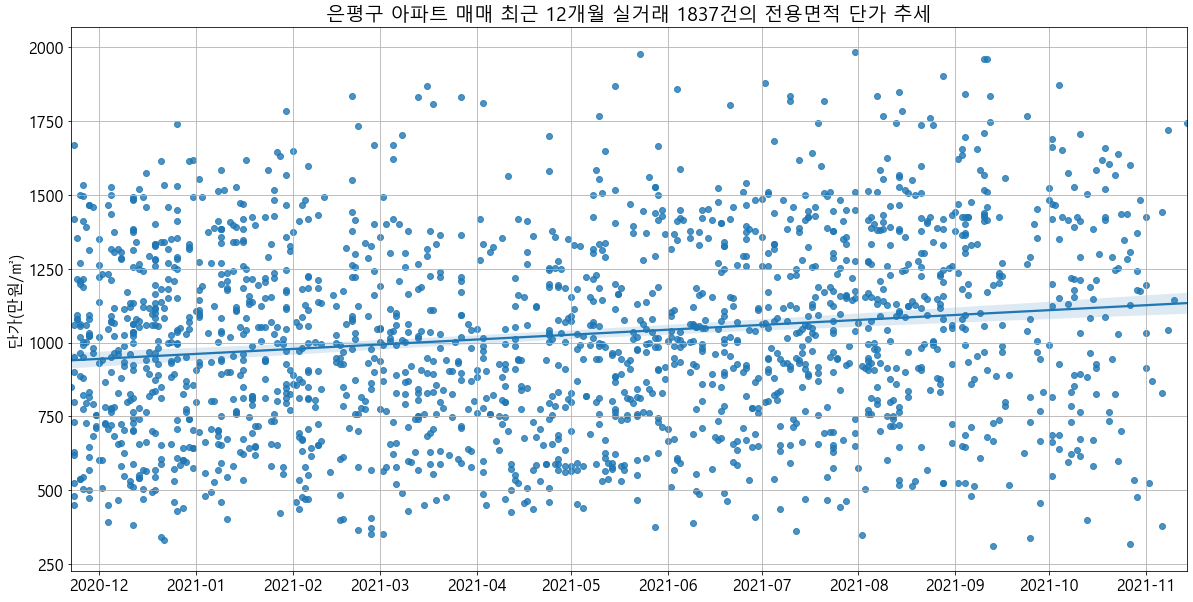

In [92]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} 아파트 매매 최근 {}개월 실거래 {}건의 전용면적 단가 추세'.format(target_gu, 12, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

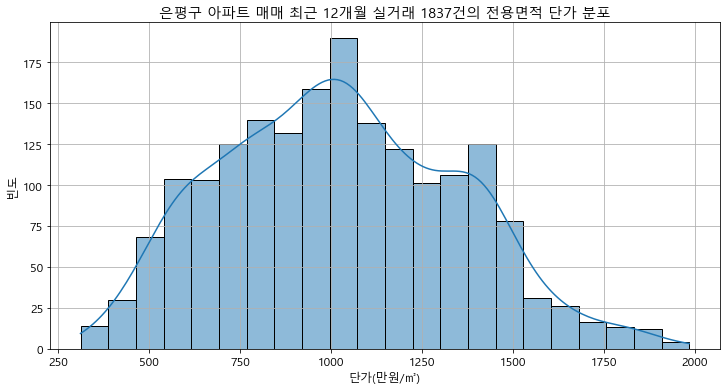

In [91]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} 아파트 매매 최근 12개월 실거래 {}건의 전용면적 단가 분포'.format(target_gu, target_df.shape[0]))
plt.grid(True)
plt.ylabel('빈도')
sns.histplot(target_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/분포도.png'.format(target_gu, target_dong, date_today_record))

In [27]:
print(target_df.shape)
target_df.head()

(1837, 10)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형
0,서울특별시 은평구 갈현동 136-6,대훈,19,3,매매,82.62,2021-06-26,55300,669.329460,아파트
1,서울특별시 은평구 갈현동 241-9,한아름,18,4,매매,74.14,2021-10-23,44500,600.215808,아파트
2,서울특별시 은평구 갈현동 267-1,라이프시티,30,2,매매,79.11,2020-12-19,43000,543.546960,아파트
3,서울특별시 은평구 갈현동 267-1,라이프시티,30,5,매매,76.34,2021-01-04,42600,558.029866,아파트
4,서울특별시 은평구 갈현동 267-1,라이프시티,30,11,매매,79.11,2021-03-20,50000,632.031349,아파트


In [28]:
target_df['건물(단지)명'].value_counts()

북한산현대힐스테이트3차아파트          44
라이프미성                    43
북한산푸르지오                  43
래미안베라힐즈                  32
백련산힐스테이트2차               31
대림한숲(DMC이편한세상)           29
백련산힐스테이트1차               27
백련산힐스테이트4차               26
힐스테이트녹번                  26
북한산힐스테이트1차아파트            24
북한산힐스테이트7차               23
아그네스풍림아이원                23
녹번JR아파트                  21
응암역효성해링턴플레이스             21
DMC우방                    21
백련산힐스테이트3차               21
백련산에스케이뷰아이파크             21
북한산현대홈타운                 21
힐데스하임                    19
경남아너스빌                   19
은평뉴타운마고정(센트레빌3단지)        19
효민아크로뷰                   18
은평뉴타운우물골(두산위브8단지)        18
백련산파크자이                  17
은평뉴타운기자촌11단지             17
은평뉴타운 제각말 푸르지오(5-3단지)    16
신동아                      15
진흥엣세벨                    15
갈현현대                     15
은평뉴타운엘크루                 15
은평스카이뷰자이                 15
은평뉴타운솔하임                 14
라이프씨티                    14
은평뉴타운박석고개(힐스테이트1단지)      14
갈현1단지e-편한세상              13
베로니스                

In [62]:
target_df['건물(단지)명'].nunique()

337

In [64]:
target_df['건물(단지)명'].unique()[:100]

array(['대훈', '한아름', '라이프시티', '대양', '인우(281-236)', '힐튼', '해오름',
       '수정럭스(428-6)', '연서노벨(463-16)', '동광갈현베르빌', '역촌맨션', '플라잉캐슬', '베로니스',
       '행운', '수정럭스', '지캐슬', '선구', '명성', '웰빙', '웰빙존', '아름(526-2)', '갈현동현대',
       '미미', '한솔', '우남', '갈현건영', '현재트윈빌', '메카', '갈현삼성', '코오롱하늘채', '유호루하스',
       '에덴드림', '뉴월드빌(16-28)', '캐슬아파트(18-10)', '동양', '송학', '그린', '온세',
       '우신', '태영홈아파트', '엔에스아파트', '예승빌라트', '브라운스톤구산', '경향', '명남아파트',
       '경남아너스빌', '한국프라우드', '구산그린빌', '세영아파트', '은평서해그랑블', '이안', '벨뷰아파트',
       '동익파크(355-95)', '동익파크(355-98)', '갈현현대', '대림e-편한세상2', '갈현1단지e-편한세상',
       '청솔아파트', '경원파발리안', '산수(86-20)', '초우레디안아트빌', '녹번현대아파트', '동호스카이',
       '유일아트리움', '거장메카', '대림아파트(276)', '녹번2현대', '해주드림빌', '녹번JR아파트',
       '북한산푸르지오', '힐스테이트녹번', '래미안베라힐즈', '정익제이원', '대조리치빌III', '벽산메트로시티',
       '제이타워1', '아이안빌', '예가크레시아', '미래하임', '나이스홈', '미래하임(6-19)', '영화빌리지',
       '주주베에이', '모아아파트(A동)', '모아아파트', '주주베B', '해오름시티', '대경홈타운',
       '미래하임(9-46)', '유성아이비아파트', '서경아파트(15-58)', '정익제이원아파트(15-114)',
       '보성리엔

In [73]:
def famous_brand_filter(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    
    x = str(x)
    
    brands_list = ['푸르지오', '편한세상', '래미안', '레미안', '아이파크', '자이', '힐스테이트']
    
    for brand in brands_list:
        if brand in x:
            return 'Y'
    
    return 'N'

In [74]:
target_df['유명브랜드'] = target_df['건물(단지)명'].apply(famous_brand_filter)

In [75]:
print(target_df.shape)
target_df.head()

(1837, 11)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,유명브랜드
0,서울특별시 은평구 갈현동 136-6,대훈,19,3,매매,82.62,2021-06-26,55300,669.329460,아파트,N
1,서울특별시 은평구 갈현동 241-9,한아름,18,4,매매,74.14,2021-10-23,44500,600.215808,아파트,N
2,서울특별시 은평구 갈현동 267-1,라이프시티,30,2,매매,79.11,2020-12-19,43000,543.546960,아파트,N
3,서울특별시 은평구 갈현동 267-1,라이프시티,30,5,매매,76.34,2021-01-04,42600,558.029866,아파트,N
4,서울특별시 은평구 갈현동 267-1,라이프시티,30,11,매매,79.11,2021-03-20,50000,632.031349,아파트,N


In [76]:
sorted_df = target_df.sort_values(['단가(만원/㎡)'], ascending=False)
print(sorted_df.shape)
sorted_df.head()

(1837, 11)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,유명브랜드
1414,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,4,매매,44.850,2021-07-31,89000,1984.392419,아파트,Y
1411,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,19,매매,59.960,2021-05-23,118500,1976.317545,아파트,Y
1415,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,15,매매,59.960,2021-09-10,117500,1959.639760,아파트,Y
1416,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,18,매매,59.970,2021-09-11,117500,1959.312990,아파트,Y
316,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,13,매매,59.938,2021-08-28,114000,1901.965364,아파트,Y


In [85]:
sorted_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/실거래가_건물연식무관_계약최근12개월_단가순정렬.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [72]:
sorted_df.head(100)

,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,유명브랜드
1414,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,4,매매,44.8500,2021-07-31,89000,1984.392419,아파트,Y
1411,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,19,매매,59.9600,2021-05-23,118500,1976.317545,아파트,Y
1415,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,15,매매,59.9600,2021-09-10,117500,1959.639760,아파트,Y
1416,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,18,매매,59.9700,2021-09-11,117500,1959.312990,아파트,Y
316,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,13,매매,59.9380,2021-08-28,114000,1901.965364,아파트,N
336,서울특별시 은평구 녹번동 283-0,래미안베라힐즈,2,5,매매,59.9800,2021-07-02,112700,1878.959653,아파트,Y
350,서울특별시 은평구 녹번동 283-0,래미안베라힐즈,2,7,매매,59.9800,2021-10-04,112300,1872.290764,아파트,Y
306,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,14,매매,59.9380,2021-03-16,112000,1868.597551,아파트,N
312,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,13,매매,59.9380,2021-05-15,112000,1868.597551,아파트,N
1412,서울특별시 은평구 응암동 769-0,녹번역e편한세상캐슬,0,17,매매,59.9700,2021-06-04,111500,1859.262965,아파트,Y


In [78]:
brand_df = target_df[target_df['유명브랜드'] == 'Y']
print(brand_df.shape)
brand_df.head()

(591, 11)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,유명브랜드
185,서울특별시 은평구 구산동 546-0,대림e-편한세상2,17,7,매매,84.618,2021-02-23,66000,779.975892,아파트,Y
186,서울특별시 은평구 구산동 546-0,대림e-편한세상2,17,14,매매,110.415,2021-04-27,74400,673.821492,아파트,Y
187,서울특별시 은평구 구산동 546-0,대림e-편한세상2,17,5,매매,59.886,2021-06-08,60000,1001.903617,아파트,Y
188,서울특별시 은평구 구산동 547-0,갈현1단지e-편한세상,17,17,매매,84.618,2020-11-30,64000,756.340259,아파트,Y
189,서울특별시 은평구 구산동 547-0,갈현1단지e-편한세상,17,11,매매,84.618,2020-12-14,66000,779.975892,아파트,Y


In [79]:
brand_df['건물(단지)명'].value_counts()

북한산현대힐스테이트3차아파트          44
북한산푸르지오                  43
래미안베라힐즈                  32
백련산힐스테이트2차               31
대림한숲(DMC이편한세상)           29
백련산힐스테이트1차               27
백련산힐스테이트4차               26
힐스테이트녹번                  26
북한산힐스테이트1차아파트            24
북한산힐스테이트7차               23
백련산힐스테이트3차               21
백련산에스케이뷰아이파크             21
백련산파크자이                  17
은평뉴타운 제각말 푸르지오(5-3단지)    16
은평스카이뷰자이                 15
은평뉴타운박석고개(힐스테이트1단지)      14
갈현1단지e-편한세상              13
대우푸르지오                   13
은평뉴타운상림마을(푸르지오C-5)       12
북한산래미안아파트(1단지)           12
은평뉴타운상림마을(현대아이파크B-13)    11
북한산래미안아파트(2단지)           11
녹번역e편한세상캐슬               10
은평뉴타운 제각말 푸르지오(5-4단지)    10
은평뉴타운박석고개(힐스테이트12단지)      9
은평뉴타운 제각말 푸르지오(5-1단지)     9
은평뉴타운상림마을(푸르지오C-6)        9
은평뉴타운상림마을(현대아이파크B-14)     8
은평뉴타운상림마을(현대아이파크B-4)      7
은평뉴타운폭포동(힐스테이트D-9)        7
은평뉴타운구파발(삼성래미안9단지)        6
은평뉴타운 제각말 푸르지오(5-2단지)     6
은평뉴타운상림마을(푸르지오C-7)        4
은평뉴타운상림마을(푸르지오C-8)        4
DMC자이1단지                  4
대림e-편한세상2           

In [83]:
new_brand_df = brand_df[brand_df['건물연식'] <= 5]
print(new_brand_df.shape)
new_brand_df.head()

(147, 11)


,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,유명브랜드
293,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,11,매매,59.938,2020-11-23,100000,1668.390670,아파트,Y
294,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,13,매매,84.900,2020-11-23,120500,1419.316843,아파트,Y
295,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,18,매매,84.900,2020-12-14,129000,1519.434629,아파트,Y
296,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,17,매매,84.898,2020-12-21,137000,1613.701147,아파트,Y
297,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,8,매매,59.900,2020-12-26,104300,1741.235392,아파트,Y


In [87]:
new_brand_df = new_brand_df.sort_values(['지번주소', '건물연식', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
new_brand_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/실거래가_건물연식5년_계약최근12개월_브랜드.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [88]:
new_brand_df.head()

,지번주소,건물(단지)명,건물연식,층,거래구분,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),부동산유형,유명브랜드
0,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,11,매매,59.938,2020-11-23,100000,1668.390670,아파트,Y
1,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,13,매매,84.900,2020-11-23,120500,1419.316843,아파트,Y
2,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,18,매매,84.900,2020-12-14,129000,1519.434629,아파트,Y
3,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,17,매매,84.898,2020-12-21,137000,1613.701147,아파트,Y
4,서울특별시 은평구 녹번동 282-0,힐스테이트녹번,2,8,매매,59.900,2020-12-26,104300,1741.235392,아파트,Y


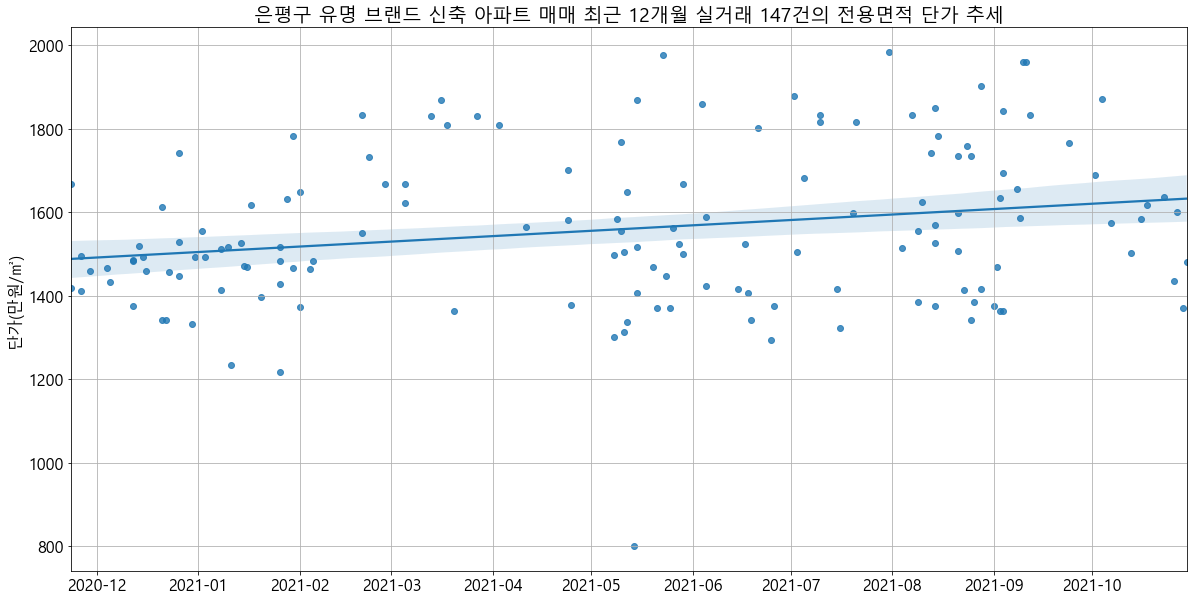

In [93]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} 유명 브랜드 신축 아파트 매매 최근 {}개월 실거래 {}건의 전용면적 단가 추세'.format(target_gu, 12, new_brand_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(new_brand_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(new_brand_df['계약날짜']), y=new_brand_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/신축_브랜드_산포도.png'.format(target_gu, target_dong, date_today_record))

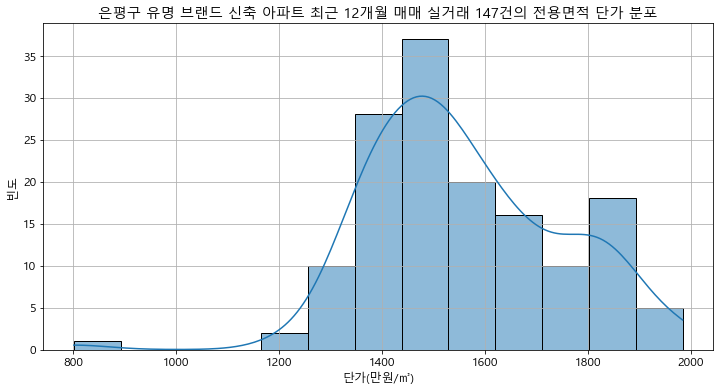

In [94]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} 유명 브랜드 신축 아파트 최근 12개월 매매 실거래 {}건의 전용면적 단가 분포'.format(target_gu, new_brand_df.shape[0]))
plt.grid(True)
plt.ylabel('빈도')
sns.histplot(new_brand_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/신축_브랜드분포도.png'.format(target_gu, target_dong, date_today_record))

In [42]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

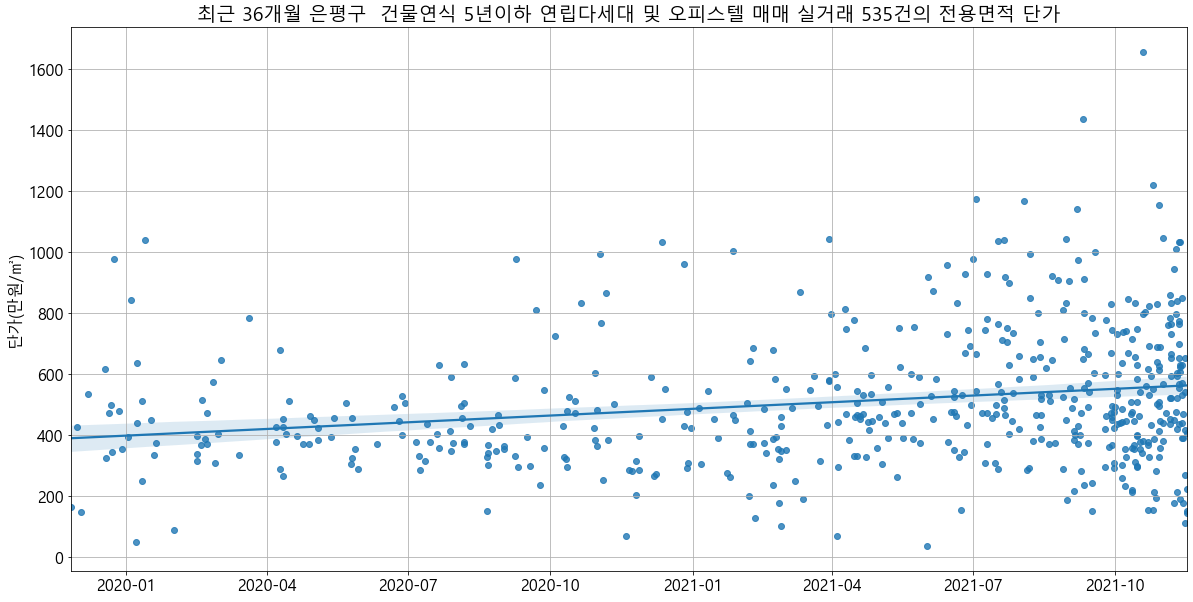

In [43]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [44]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [45]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(6687, 21)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
695051,서울특별시 은평구 갈현동 456-8,연서로29길 7-5,서울특별시 은평구 갈현동,456.0,8.0,만연센텀시티,12.30,10000,5,2014.0,NaN,NaN,전세,5.0,2019-11-23,813.008130,7.0,아파트,은평구,갈현동,N
695054,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.23,10500,7,2014.0,NaN,NaN,전세,4.0,2018-01-16,858.544563,7.0,아파트,은평구,갈현동,N
695055,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.23,11000,7,2014.0,NaN,NaN,전세,5.0,2019-03-21,899.427637,7.0,아파트,은평구,갈현동,N
695056,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.23,10500,8,2014.0,-,-,매매,5.0,2019-11-25,858.544563,7.0,아파트,은평구,갈현동,N
695057,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.23,10500,6,2014.0,-,-,매매,5.0,2019-11-25,858.544563,7.0,아파트,은평구,갈현동,N


In [46]:
target_df2 = get_index_applied_prices(target_df2)

In [48]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [49]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [50]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [51]:
concat_df = pd.concat([target_df2])

In [52]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [53]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [54]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(416, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.23,10500,5,2014.0,-,-,매매,5.0,2019-11-25,858.544563,7.0,아파트,은평구,갈현동,N,111.481,1017.899108,2021년 07월,815.997062,967.454361
1,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.44,10500,6,2014.0,-,-,매매,5.0,2019-11-25,844.051447,7.0,아파트,은평구,갈현동,N,111.481,1000.715924,2021년 07월,815.997062,967.454361
2,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,12.48,10500,5,2014.0,-,-,매매,5.0,2019-11-25,841.346154,7.0,아파트,은평구,갈현동,N,111.481,997.508501,2021년 07월,815.997062,967.454361
3,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,17.36,12500,4,2014.0,-,-,매매,5.0,2019-11-25,720.046083,7.0,아파트,은평구,갈현동,N,111.481,853.693911,2021년 07월,815.997062,967.454361
4,서울특별시 은평구 갈현동 456-8,연서로29길 7-5,서울특별시 은평구 갈현동,456.0,8.0,만연센텀시티,12.30,10000,5,2014.0,NaN,NaN,전세,5.0,2019-11-23,813.008130,7.0,아파트,은평구,갈현동,N,111.481,963.910654,2021년 07월,813.008130,963.910654


In [55]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(113, 26)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,계약날짜_실거래지수,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
3,서울특별시 은평구 갈현동 456-19,연서로29길 7-19,서울특별시 은평구 갈현동,456.0,19.0,골드스타,17.360,12500,4,2014.0,-,-,매매,5.0,2019-11-25,720.046083,7.0,아파트,은평구,갈현동,N,111.481,853.693911,2021년 07월,815.997062,967.454361
4,서울특별시 은평구 갈현동 456-8,연서로29길 7-5,서울특별시 은평구 갈현동,456.0,8.0,만연센텀시티,12.300,10000,5,2014.0,NaN,NaN,전세,5.0,2019-11-23,813.008130,7.0,아파트,은평구,갈현동,N,111.481,963.910654,2021년 07월,813.008130,963.910654
5,서울특별시 은평구 갈현동 468-4,서오릉로 156-1,서울특별시 은평구 갈현동,468.0,4.0,플라잉캐슬,55.700,55000,12,2019.0,-,-,매매,2.0,2021-07-29,987.432675,2.0,아파트,은평구,갈현동,N,132.173,987.432675,2021년 07월,987.432675,987.432675
7,서울특별시 은평구 갈현동 468-5,연서로17길 9,서울특별시 은평구 갈현동,468.0,5.0,베로니스,52.100,68000,8,2017.0,-,-,매매,4.0,2021-10-27,1305.182342,4.0,아파트,은평구,갈현동,N,지수없음,1305.182342,지수없음,1027.250571,1125.673157
18,서울특별시 은평구 갈현동 548-0,갈현로 300,서울특별시 은평구 갈현동,548.0,0.0,유호루하스,16.768,13500,4,2018.0,NaN,NaN,전세,3.0,2021-10-20,805.104962,3.0,아파트,은평구,갈현동,N,지수없음,805.104962,지수없음,692.818710,794.955214


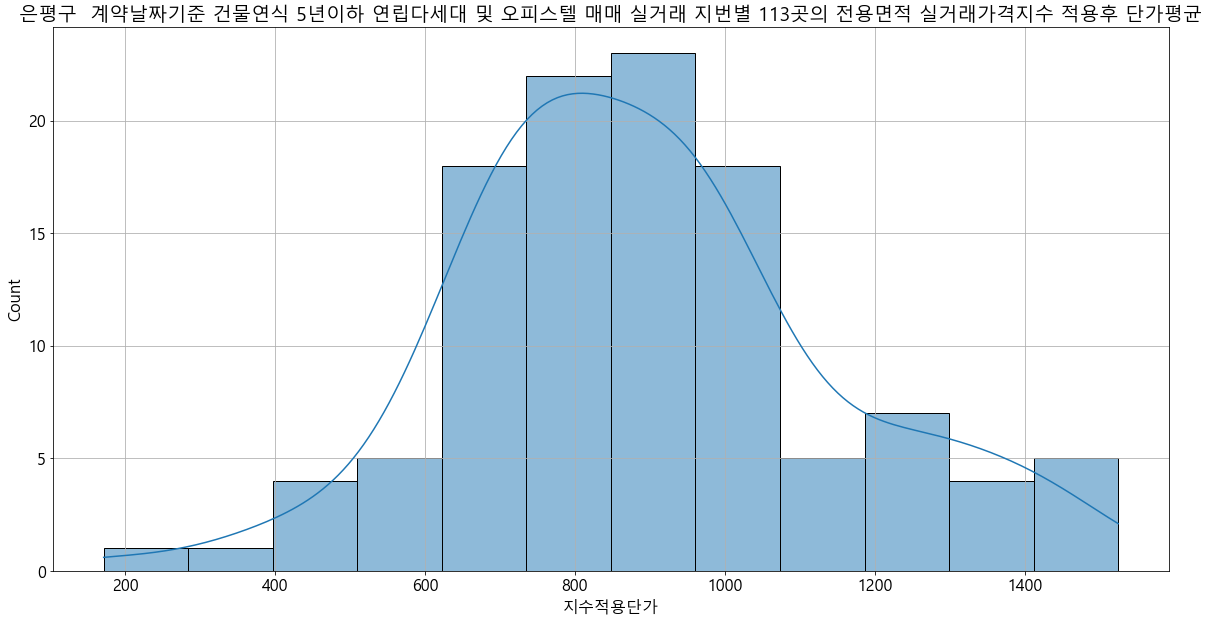

In [56]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [57]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [58]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 은평구 갈현동 456-19,골드스타,2014.0,17.360,4,2019-11-25,720.046083,2021년 07월,853.693911,아파트
1,서울특별시 은평구 갈현동 456-8,만연센텀시티,2014.0,12.300,5,2019-11-23,813.008130,2021년 07월,963.910654,아파트
2,서울특별시 은평구 갈현동 468-4,플라잉캐슬,2019.0,55.700,12,2021-07-29,987.432675,2021년 07월,987.432675,아파트
3,서울특별시 은평구 갈현동 468-5,베로니스,2017.0,52.100,8,2021-10-27,1305.182342,지수없음,1305.182342,아파트
4,서울특별시 은평구 갈현동 548-0,유호루하스,2018.0,16.768,4,2021-10-20,805.104962,지수없음,805.104962,아파트


In [59]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_아파트_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)